## CartPole

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as tud
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
env = gym.make('CartPole-v0')

In [3]:
## set seed :2345
seed = 4567
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.np_random.seed(seed)

### Method 2. DAQN

### Step 1.fill the experience set and train an auto-encoeder

In [4]:
## experience set

class Experience():
    def __init__(self, capacity = 20000):
        self.experience = []  ## store （s,a,r,s'）
        self.capacity = capacity  ## max capacity
        self.volume = 0  ## current capacity
        self.iter = 0
        
    def insert(self, transition):
        if self.volume < self.capacity:
            ## insert directly
            self.experience.append(transition)
            self.volume += 1
        else:
            ## random choose a transition to cover
            self.experience[self.iter] = transition
            self.iter = (self.iter + 1) % self.capacity
    
    def sample(self, batch_size):
        ## random sample a batch including batch_size transitions
        return random.sample(self.experience, k = batch_size)

In [5]:
experience = Experience(capacity = 20000)

while True:
    s0 = env.reset()
    is_end = False
    while not is_end:
        action = env.action_space.sample()
        s1, reward, is_end, _ = env.step(action)
        experience.insert([s0,action,reward,s1])
        s0 = s1
    if experience.volume == experience.capacity:
        break

In [6]:
## Auto Encoder

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, output_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        return hidden, output

In [7]:
# Dataset and DataLoader

class AEDataset(tud.Dataset):
    def __init__(self, experience):
        state = []
        for s in experience.experience:
            state.append(s[0])
        self.states = torch.Tensor(state)
        
    def __len__(self):
        return len(self.states)
            
    def __getitem__(self, idx):
        return self.states[idx]
    
aedataset = AEDataset(experience)
dataloader = tud.DataLoader(aedataset, batch_size = 64, shuffle = True)

In [8]:
# Pre-train

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoEncoder(4, 16, 3).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for e in range(10):
    losses = []
    for batch in dataloader:
        batch = batch.to(device)
        _, output = model(batch)
        loss = loss_fn(batch, output)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    print("epoch:", e, "loss:", round(np.mean(losses),4))
    
torch.save(model, 'saved_model\DAQN_pretrain')

epoch: 0 loss: 0.1375
epoch: 1 loss: 0.0196
epoch: 2 loss: 0.0118
epoch: 3 loss: 0.0105
epoch: 4 loss: 0.01
epoch: 5 loss: 0.0099
epoch: 6 loss: 0.0098
epoch: 7 loss: 0.0098
epoch: 8 loss: 0.0098
epoch: 9 loss: 0.0098


### Step 2. Use the hidden layer to do DQN

In [9]:
## DQN Approximator

class QNetwork(nn.Module):
    def __init__(self, action_space, model):
        super(QNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(model.input_dim, model.hidden_dim),
            nn.ReLU(),
            nn.Linear(model.hidden_dim, model.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(model.hidden_dim // 2, model.hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(model.hidden_dim // 4, model.output_dim)
        )
        self.encoder.load_state_dict(model.encoder.state_dict())
        self.Network = nn.Linear(model.output_dim, action_space)
        
    def forward(self, x):
        return self.Network(self.encoder(x))

In [10]:
## Agent

class DAQNAgent():
    def __init__(self, env, experience, model, hidden_dim, gamma = 0.9, epsilon = 0.1, decay_rate = 1, learning_rate = 1e-4):
        self.env = env
        self.action_space = env.action_space  
        self.obs_space = env.observation_space.shape[0]
        self.action_len = len([i for i in range(self.action_space.n)])
        self.experience = experience
        self.model = model
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.behaviour_QNetwork = QNetwork(self.action_len, self.model).to(self.device)
        self.target_QNetwork = QNetwork(self.action_len, self.model).to(self.device)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.behaviour_QNetwork.parameters(), lr = learning_rate)
        
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.gamma = gamma

    def policy(self, state, epsilon = 0.1):
        if np.random.random() < epsilon:
            action = self.action_space.sample()
        else:
            score = self.behaviour_QNetwork(torch.Tensor(state).to(self.device)).detach()
            action = torch.argmax(score).item()
            
        return action
    
    def learn(self, batch_size, display = False):
        s0 = self.env.reset()
        if display:
            self.env.render()
        is_end = False
        episode_reward = 0
        
        while not is_end:
            ## choose an action and make a step
            a0 = self.policy(s0, epsilon = self.epsilon)
            s1, reward, is_end, _ = self.env.step(a0)
            if display:
                self.env.render()
            if is_end:
                s1 = np.array([100,100,100,100])
            ## store the transition into experience
            self.experience.insert([s0,a0,reward,s1])
            ## sample minibatch from experience
            minibatch = self.experience.sample(batch_size = batch_size)
            s, a, r, s_next = [], [], [], []
            for batch in minibatch:
                s.append(batch[0])
                a.append(batch[1])
                r.append(batch[2])
                s_next.append(batch[3])
            s = torch.Tensor(s).to(self.device)
            a = torch.LongTensor(a).to(self.device).reshape(-1,1)
            r = torch.Tensor(r).to(self.device).reshape(-1,1)
            s_next = torch.Tensor(s_next).to(self.device)
            Q_target = r + self.gamma * torch.max(self.target_QNetwork(s_next),1)[0].reshape(-1,1) * (s_next[:,0] != 100).reshape(-1,1)
            Q_behaviour = self.behaviour_QNetwork(s).gather(1,a)
            loss = self.loss_fn(Q_target, Q_behaviour)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            ## iteration
            s0 = s1
            episode_reward += reward
        
        ## update target network
        self.target_QNetwork.load_state_dict(self.behaviour_QNetwork.state_dict())
        self.epsilon *= self.decay_rate
        
        return episode_reward, loss.item()
    
    def save_model(self):
        torch.save(self.behaviour_QNetwork, 'saved_model\DAQN')
        
    def load_model(self):
        self.behaviour_QNetwork = torch.load('saved_model\DAQN')
        self.target_QNetwork.load_state_dict(self.behaviour_QNetwork.state_dict())


In [11]:
## train
daqn_agent = DAQNAgent(env, experience, model, hidden_dim = 16, gamma = 0.99, epsilon = 0.1, decay_rate = 0.9, learning_rate = 1e-3)
MAX_EPISODE = 2000
daqn_episode_reward = []
daqn_loss = []
average_100_step = []

save_flag = False
max_reward = 0

for e in tqdm(range(MAX_EPISODE)):
    reward, loss = daqn_agent.learn(batch_size = 100, display = False)
    daqn_episode_reward.append(reward)
    avg_mean = np.mean(daqn_episode_reward[-100:])
    average_100_step.append(avg_mean)
    daqn_loss.append(loss)
    
    ## save model
    if avg_mean > 180:
        if save_flag == False:
            daqn_agent.save_model()
            save_flag = True
            max_reward = avg_mean
            print("model saved, episode:",e,"average mean of last 100 episodes:",avg_mean)
        else:
            if avg_mean >= max_reward:
                daqn_agent.save_model()
                max_reward = avg_mean
                print("model saved, episode:",e,"average mean of last 100 episodes:",avg_mean)
    

 46%|███████████████████████████████████▉                                           | 910/2000 [05:22<17:10,  1.06it/s]

model saved, episode: 909 average mean of last 100 episodes: 180.49


 46%|███████████████████████████████████▉                                           | 911/2000 [05:23<18:12,  1.00s/it]

model saved, episode: 910 average mean of last 100 episodes: 180.51


 46%|████████████████████████████████████                                           | 912/2000 [05:24<18:21,  1.01s/it]

model saved, episode: 911 average mean of last 100 episodes: 180.82


 46%|████████████████████████████████████                                           | 913/2000 [05:25<18:29,  1.02s/it]

model saved, episode: 912 average mean of last 100 episodes: 181.07


 46%|████████████████████████████████████                                           | 914/2000 [05:26<18:41,  1.03s/it]

model saved, episode: 913 average mean of last 100 episodes: 181.33


 46%|████████████████████████████████████▏                                          | 915/2000 [05:27<18:17,  1.01s/it]

model saved, episode: 914 average mean of last 100 episodes: 181.39


 46%|████████████████████████████████████▏                                          | 916/2000 [05:28<18:12,  1.01s/it]

model saved, episode: 915 average mean of last 100 episodes: 181.47


 46%|████████████████████████████████████▏                                          | 917/2000 [05:29<17:55,  1.01it/s]

model saved, episode: 916 average mean of last 100 episodes: 181.91


 46%|████████████████████████████████████▎                                          | 918/2000 [05:30<17:24,  1.04it/s]

model saved, episode: 917 average mean of last 100 episodes: 182.27


 46%|████████████████████████████████████▎                                          | 919/2000 [05:31<17:06,  1.05it/s]

model saved, episode: 918 average mean of last 100 episodes: 182.42


 46%|████████████████████████████████████▌                                          | 925/2000 [05:35<15:20,  1.17it/s]

model saved, episode: 924 average mean of last 100 episodes: 182.72


 46%|████████████████████████████████████▌                                          | 926/2000 [05:36<15:50,  1.13it/s]

model saved, episode: 925 average mean of last 100 episodes: 182.88


 46%|████████████████████████████████████▌                                          | 927/2000 [05:37<16:12,  1.10it/s]

model saved, episode: 926 average mean of last 100 episodes: 183.05


 46%|████████████████████████████████████▋                                          | 928/2000 [05:38<16:37,  1.07it/s]

model saved, episode: 927 average mean of last 100 episodes: 183.16


 46%|████████████████████████████████████▋                                          | 929/2000 [05:39<16:56,  1.05it/s]

model saved, episode: 928 average mean of last 100 episodes: 183.16


 46%|████████████████████████████████████▋                                          | 930/2000 [05:40<16:44,  1.07it/s]

model saved, episode: 929 average mean of last 100 episodes: 183.41


 47%|████████████████████████████████████▊                                          | 931/2000 [05:41<16:52,  1.06it/s]

model saved, episode: 930 average mean of last 100 episodes: 183.41


 48%|█████████████████████████████████████▉                                         | 962/2000 [06:08<16:37,  1.04it/s]

model saved, episode: 961 average mean of last 100 episodes: 183.61


 48%|██████████████████████████████████████                                         | 963/2000 [06:09<16:37,  1.04it/s]

model saved, episode: 962 average mean of last 100 episodes: 184.17


 48%|██████████████████████████████████████                                         | 964/2000 [06:10<16:39,  1.04it/s]

model saved, episode: 963 average mean of last 100 episodes: 184.81


 48%|██████████████████████████████████████                                         | 965/2000 [06:11<16:43,  1.03it/s]

model saved, episode: 964 average mean of last 100 episodes: 185.47


 48%|██████████████████████████████████████▏                                        | 966/2000 [06:12<16:37,  1.04it/s]

model saved, episode: 965 average mean of last 100 episodes: 185.91


 48%|██████████████████████████████████████▏                                        | 967/2000 [06:13<16:31,  1.04it/s]

model saved, episode: 966 average mean of last 100 episodes: 186.41


 48%|██████████████████████████████████████▏                                        | 968/2000 [06:14<16:30,  1.04it/s]

model saved, episode: 967 average mean of last 100 episodes: 186.95


 48%|██████████████████████████████████████▎                                        | 969/2000 [06:15<16:22,  1.05it/s]

model saved, episode: 968 average mean of last 100 episodes: 187.54


 48%|██████████████████████████████████████▎                                        | 970/2000 [06:16<16:24,  1.05it/s]

model saved, episode: 969 average mean of last 100 episodes: 188.27


 49%|██████████████████████████████████████▎                                        | 971/2000 [06:17<16:16,  1.05it/s]

model saved, episode: 970 average mean of last 100 episodes: 188.98


 49%|██████████████████████████████████████▍                                        | 972/2000 [06:17<16:13,  1.06it/s]

model saved, episode: 971 average mean of last 100 episodes: 189.61


 49%|██████████████████████████████████████▍                                        | 974/2000 [06:19<15:39,  1.09it/s]

model saved, episode: 973 average mean of last 100 episodes: 190.15


 49%|██████████████████████████████████████▌                                        | 975/2000 [06:20<15:57,  1.07it/s]

model saved, episode: 974 average mean of last 100 episodes: 190.57


 49%|██████████████████████████████████████▌                                        | 976/2000 [06:21<15:59,  1.07it/s]

model saved, episode: 975 average mean of last 100 episodes: 190.62


 49%|██████████████████████████████████████▌                                        | 977/2000 [06:22<16:03,  1.06it/s]

model saved, episode: 976 average mean of last 100 episodes: 190.85


 49%|██████████████████████████████████████▋                                        | 978/2000 [06:23<15:59,  1.07it/s]

model saved, episode: 977 average mean of last 100 episodes: 191.12


 49%|██████████████████████████████████████▋                                        | 979/2000 [06:24<16:00,  1.06it/s]

model saved, episode: 978 average mean of last 100 episodes: 191.12


 49%|██████████████████████████████████████▊                                        | 982/2000 [06:25<11:32,  1.47it/s]

model saved, episode: 979 average mean of last 100 episodes: 191.12


 56%|███████████████████████████████████████████▉                                  | 1128/2000 [08:19<13:53,  1.05it/s]

model saved, episode: 1127 average mean of last 100 episodes: 191.23


 56%|████████████████████████████████████████████                                  | 1129/2000 [08:20<14:06,  1.03it/s]

model saved, episode: 1128 average mean of last 100 episodes: 192.56


 56%|████████████████████████████████████████████                                  | 1130/2000 [08:21<14:10,  1.02it/s]

model saved, episode: 1129 average mean of last 100 episodes: 193.55


 57%|████████████████████████████████████████████                                  | 1131/2000 [08:22<14:07,  1.03it/s]

model saved, episode: 1130 average mean of last 100 episodes: 194.27


 57%|████████████████████████████████████████████▏                                 | 1132/2000 [08:23<14:00,  1.03it/s]

model saved, episode: 1131 average mean of last 100 episodes: 194.27


 57%|████████████████████████████████████████████▏                                 | 1133/2000 [08:24<13:57,  1.03it/s]

model saved, episode: 1132 average mean of last 100 episodes: 194.27


 57%|████████████████████████████████████████████▏                                 | 1134/2000 [08:25<13:48,  1.05it/s]

model saved, episode: 1133 average mean of last 100 episodes: 194.27


 57%|████████████████████████████████████████████▎                                 | 1135/2000 [08:26<13:43,  1.05it/s]

model saved, episode: 1134 average mean of last 100 episodes: 194.27


 57%|████████████████████████████████████████████▎                                 | 1136/2000 [08:27<13:52,  1.04it/s]

model saved, episode: 1135 average mean of last 100 episodes: 194.27


 57%|████████████████████████████████████████████▎                                 | 1137/2000 [08:28<13:49,  1.04it/s]

model saved, episode: 1136 average mean of last 100 episodes: 194.28


 57%|████████████████████████████████████████████▍                                 | 1138/2000 [08:29<14:08,  1.02it/s]

model saved, episode: 1137 average mean of last 100 episodes: 194.4


 57%|████████████████████████████████████████████▍                                 | 1139/2000 [08:30<14:12,  1.01it/s]

model saved, episode: 1138 average mean of last 100 episodes: 194.63


 57%|████████████████████████████████████████████▍                                 | 1140/2000 [08:31<14:01,  1.02it/s]

model saved, episode: 1139 average mean of last 100 episodes: 195.08


 57%|████████████████████████████████████████████▍                                 | 1141/2000 [08:32<14:01,  1.02it/s]

model saved, episode: 1140 average mean of last 100 episodes: 195.72


 57%|████████████████████████████████████████████▌                                 | 1142/2000 [08:33<13:47,  1.04it/s]

model saved, episode: 1141 average mean of last 100 episodes: 196.59


 57%|████████████████████████████████████████████▌                                 | 1143/2000 [08:34<13:43,  1.04it/s]

model saved, episode: 1142 average mean of last 100 episodes: 196.59


 57%|████████████████████████████████████████████▌                                 | 1144/2000 [08:35<13:32,  1.05it/s]

model saved, episode: 1143 average mean of last 100 episodes: 196.59


 57%|████████████████████████████████████████████▋                                 | 1145/2000 [08:36<13:29,  1.06it/s]

model saved, episode: 1144 average mean of last 100 episodes: 196.59


 57%|████████████████████████████████████████████▋                                 | 1146/2000 [08:37<13:24,  1.06it/s]

model saved, episode: 1145 average mean of last 100 episodes: 196.59


 57%|████████████████████████████████████████████▋                                 | 1147/2000 [08:38<13:17,  1.07it/s]

model saved, episode: 1146 average mean of last 100 episodes: 196.59


 57%|████████████████████████████████████████████▊                                 | 1148/2000 [08:38<13:16,  1.07it/s]

model saved, episode: 1147 average mean of last 100 episodes: 196.59


 57%|████████████████████████████████████████████▊                                 | 1149/2000 [08:39<13:15,  1.07it/s]

model saved, episode: 1148 average mean of last 100 episodes: 196.59


 58%|████████████████████████████████████████████▉                                 | 1151/2000 [08:41<12:38,  1.12it/s]

model saved, episode: 1150 average mean of last 100 episodes: 196.59


 58%|█████████████████████████████████████████████                                 | 1154/2000 [08:44<12:06,  1.16it/s]

model saved, episode: 1153 average mean of last 100 episodes: 196.9


 58%|█████████████████████████████████████████████                                 | 1155/2000 [08:44<12:07,  1.16it/s]

model saved, episode: 1154 average mean of last 100 episodes: 197.2


 58%|█████████████████████████████████████████████                                 | 1156/2000 [08:45<12:18,  1.14it/s]

model saved, episode: 1155 average mean of last 100 episodes: 197.43


 58%|█████████████████████████████████████████████                                 | 1157/2000 [08:46<12:37,  1.11it/s]

model saved, episode: 1156 average mean of last 100 episodes: 197.43


 58%|█████████████████████████████████████████████▏                                | 1158/2000 [08:47<12:50,  1.09it/s]

model saved, episode: 1157 average mean of last 100 episodes: 197.44


 58%|█████████████████████████████████████████████▏                                | 1159/2000 [08:48<12:56,  1.08it/s]

model saved, episode: 1158 average mean of last 100 episodes: 197.44


 58%|█████████████████████████████████████████████▏                                | 1160/2000 [08:49<13:04,  1.07it/s]

model saved, episode: 1159 average mean of last 100 episodes: 197.44


 58%|█████████████████████████████████████████████▎                                | 1163/2000 [08:52<13:42,  1.02it/s]

model saved, episode: 1162 average mean of last 100 episodes: 198.52


 58%|█████████████████████████████████████████████▍                                | 1164/2000 [08:53<13:37,  1.02it/s]

model saved, episode: 1163 average mean of last 100 episodes: 198.52


 58%|█████████████████████████████████████████████▍                                | 1165/2000 [08:54<13:32,  1.03it/s]

model saved, episode: 1164 average mean of last 100 episodes: 198.52


 58%|█████████████████████████████████████████████▍                                | 1166/2000 [08:55<13:23,  1.04it/s]

model saved, episode: 1165 average mean of last 100 episodes: 198.52


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [17:10<00:00,  1.94it/s]


Text(0, 0.5, 'reward')

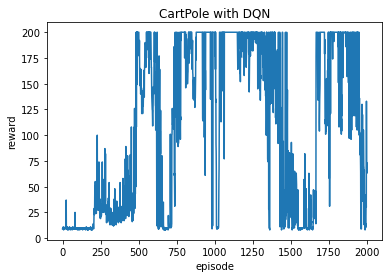

In [12]:
# outcome of each episode
plt.plot(daqn_episode_reward)
plt.title("CartPole with DQN")
plt.xlabel("episode")
plt.ylabel("reward")

Text(0, 0.5, 'reward')

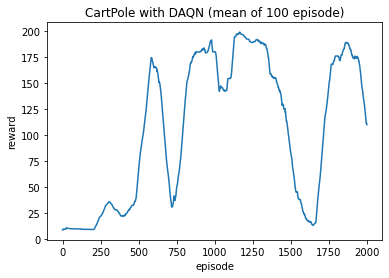

In [13]:
plt.plot(average_100_step)
plt.title("CartPole with DAQN (mean of 100 episode)")
plt.xlabel("episode")
plt.ylabel("reward")

Text(0, 0.5, 'loss')

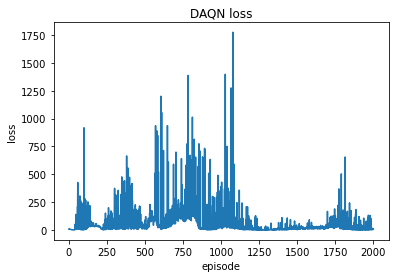

In [14]:
plt.plot(daqn_loss)
plt.title('DAQN loss')
plt.xlabel('episode')
plt.ylabel('loss')

In [15]:
# save learning curve
dqn_curve = np.array(average_100_step)
np.save('curve\DAQN', dqn_curve)